# Libraries import

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"
# %cd /content/gdrive/My Drive/Colab Notebooks

In [ ]:
# # uncomment this cell for first run to install the packages.
# !pip install quandl
# !pip install ta 
# !pip install git+https://github.com/ourownstory/neural_prophet.git
# !pip install -U prophet
# !pip install  -U statsmodels
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U pmdarima

# !pip --version
# !pip install quandl
# !pip install  statsmodels
# !pip install pycaret
# !pip install kats
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U sklearn
# !pip install ta 
# !pip install -U pmdarima


In [ ]:
# import os
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
from sklearn.model_selection import train_test_split

# stats models
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt

from pmdarima import auto_arima
from fbprophet import Prophet
import copy
import random
import sys
import itertools
import warnings
import os
warnings.filterwarnings('ignore')

In [ ]:
path = './Outputs/'
if(not os.path.isdir(path)):
    os.mkdir(path)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
quandl.ApiConfig.api_key = "2At3atzXCrMx_BXfkyz7"
# 6b7jcHuxwW7Wot1kyFNS

# Data to be used

In [ ]:
metadata = pd.read_csv('BSE_metadata.csv')
metadata.head()

,code,name,description,refreshed_at,from_date,to_date
0,BOM500002,ABB India Limited EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
1,BOM500003,AEGIS LOGISTICS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
2,BOM500008,AMARA RAJA BATTERIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
3,BOM500009,AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
4,BOM500010,HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,1/3/1992,1/18/2021


## Utility variables and functions

In [ ]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [ ]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [ ]:
start_date = '2020-03-02'
end_date = '2021-03-23'

In [ ]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = stocks):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [ ]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
#     print(result)
    out = pd.Series(result[0:4], index=label)
    out['Stock Name'] = getStockNameFromStockCode(title)
    out['Stock Code'] = title
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
#     print(out)
    if(result[1]<0.05):
        return out, 'Stationary'
    else:
        return out, 'Non-Stationary'

In [ ]:
stockMetadata = metadata[metadata['code'].isin(allSymbols)]
stockMetadata.head()

,code,name,description,refreshed_at,from_date,to_date
70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021
121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021


In [ ]:
print(stockMetadata.shape)
print(stockMetadata[stockMetadata['code'].isin(stocks)].shape)
print(stockMetadata[stockMetadata['code'].isin(indices)].shape)

(21, 6)
(15, 6)
(6, 6)


## Map Index to  stocks

In [ ]:
stockMetadata.loc[:, 'isStock'] = 0
stockMetadata.loc[:, 'Index'] = ''

stockMetadata.loc[stockMetadata['code'].isin(stocks), 'isStock'] = 1
stockMetadata.reset_index(inplace=True)

In [ ]:
stockMetadata.loc[stockMetadata['code'].isin(healthcare), 'Index'] = BSE_HEALTHCARE
stockMetadata.loc[stockMetadata['code'].isin(banking), 'Index'] = BSE_BANKEX
stockMetadata.loc[stockMetadata['code'].isin(metals), 'Index'] = BSE_METAL
stockMetadata.loc[stockMetadata['code'].isin(auto), 'Index'] = BSE_AUTO
stockMetadata.loc[stockMetadata['code'].isin(it), 'Index'] = BSE_Information_Technology

In [ ]:
stockMetadata.head()

,index,code,name,description,refreshed_at,from_date,to_date,isStock,Index
0,70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021,1,SI0800
1,104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021,1,SIBANK
2,121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1000
3,133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1200
4,146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SIBANK


In [ ]:
stockMetadata['isStock'].value_counts()

1    15
0     6
Name: isStock, dtype: int64

# Code to download the data from quandl. 

In [ ]:
# # download the required data - needed only 1 time
# i=0
# code = f'BSE/{stockMetadata.loc[i, "code"]}'
# dataset = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
# dataset['StockName']=stockMetadata.loc[i, 'name']
# dataset['code'] = stockMetadata.loc[i, "code"]
# dataset['isStock'] = stockMetadata.loc[i, "isStock"]
# dataset['Index'] = stockMetadata.loc[i, "Index"]
# for i in range(1, len(stockMetadata)):
#     code = f'BSE/{stockMetadata.loc[i, "code"]}'
#     temp = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
#     temp['StockName']=stockMetadata.loc[i, 'name']
#     temp['code'] = stockMetadata.loc[i, "code"]
#     temp['isStock'] = stockMetadata.loc[i, "isStock"]
#     temp['Index'] = stockMetadata.loc[i, "Index"]
# #     print( stockMetadata.loc[i, "Index"])
#     dataset = dataset.append(temp)
# dataset.to_csv('data.csv')
# dataset.head()

In [ ]:
# dataset = pd.read_csv('data.csv')
# dataset.head()
dataset = pd.read_csv('TimeSeriesData.csv')
dataset.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
0,2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
1,2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2,2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
3,2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
4,2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105449 entries, 0 to 105448
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       105449 non-null  object 
 1   Open                       95130 non-null   float64
 2   High                       95130 non-null   float64
 3   Low                        95130 non-null   float64
 4   Close                      105449 non-null  float64
 5   WAP                        74255 non-null   float64
 6   No. of Shares              74255 non-null   float64
 7   No. of Trades              74255 non-null   float64
 8   Total Turnover             74255 non-null   float64
 9   Deliverable Quantity       68110 non-null   float64
 10  % Deli. Qty to Traded Qty  68110 non-null   float64
 11  Spread H-L                 74255 non-null   float64
 12  Spread C-O                 74255 non-null   float64
 13  StockName                  10

### Verify the min and max of dates of all selected stocks and indices

In [ ]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges.columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']
dateRanges

,Stock Code,Stock Name,First Date,Last Date
0,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,2000-01-03,2021-03-23
1,BOM500180,HDFC Bank Ltd EOD Prices,2000-01-03,2021-03-23
2,BOM500209,INFOSYS LTD. EOD Prices,2000-01-03,2021-03-23
3,BOM500228,JSW STEEL LTD. EOD Prices,2000-01-03,2021-03-23
4,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,2000-01-03,2021-03-23
5,BOM500440,HINDALCO INDUSTRIES LTD. EOD Prices,2000-01-03,2021-03-23
6,BOM500470,TATA STEEL LTD. EOD Prices,2000-01-03,2021-03-23
7,BOM500570,TATA MOTORS LTD. EOD Prices,2000-01-03,2021-03-23
8,BOM507685,WIPRO LTD. EOD Prices,2000-01-03,2021-03-23
9,BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,2000-01-03,2021-03-23


In [ ]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges['Stock Code']==stockCode, 'Stock Name'].values[0].replace('EOD Prices', '');

In [ ]:
data = dataset.set_index('Date')
data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
Date,,,,,,,,,,,,,,,,
2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


### Populate dictionary to hold individual Stock Data

In [ ]:
# ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]

### View null values in the data 

In [ ]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538


# Deriving Technical indicators 

### MACD

In [ ]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [ ]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

### RSI - Relative Strength Index

In [ ]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [ ]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

### ATR

In [ ]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [ ]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

### Bollinger band

In [ ]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [ ]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

### OBV

In [ ]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [ ]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

### ADX

In [ ]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [ ]:
# ADX
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

In [ ]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538


# Removing Extra Columms

In [ ]:
OriginalScriptWiseData = ScriptWiseData
for symbol in allSymbols:
    ScriptWiseData[symbol] = ScriptWiseData[symbol][['Close']+TechnicalIndicators]

## Dropping null values

In [ ]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
#     ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna()    

In [ ]:
# ScriptWiseData['BOM500180'][ScriptWiseData['BOM500180']['MACD'].isna()]
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RSI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MACD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OBV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
finalDateRanges =pd.DataFrame(columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']) 
for s in stocks:
    r = [s, getStockNameFromStockCode(s), ScriptWiseData[s].index.min(),  ScriptWiseData[s].index.max()]
    finalDateRanges.loc[len(finalDateRanges)] = r
finalDateRanges

,Stock Code,Stock Name,First Date,Last Date
0,BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD.,2000-02-10,2021-03-23
1,BOM532488,DIVI'S LABORATORIES LTD.,2003-04-23,2021-03-23
2,BOM500124,DR.REDDY'S LABORATORIES LTD.,2000-02-10,2021-03-23
3,BOM500180,HDFC Bank Ltd,2000-02-10,2021-03-23
4,BOM532174,ICICI BANK LTD.,2000-02-10,2021-03-23
5,BOM500247,KOTAK MAHINDRA BANK LTD.,2000-02-10,2021-03-23
6,BOM500470,TATA STEEL LTD.,2000-02-10,2021-03-23
7,BOM500228,JSW STEEL LTD.,2000-02-10,2021-03-23
8,BOM500440,HINDALCO INDUSTRIES LTD.,2000-02-10,2021-03-23
9,BOM532977,BAJAJ AUTO LTD.,2008-07-02,2021-03-23


# ADF Test for closing price

In [ ]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Close, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Close, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTest.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD.,BOM524715,-5.02575,1.97306e-05,0,5253,-3.4316,-2.86209,-2.56706,Stationary
DIVI'S LABORATORIES LTD.,BOM532488,-3.57137,0.0063325,32,4424,-3.43183,-2.86219,-2.56712,Stationary
DR.REDDY'S LABORATORIES LTD.,BOM500124,-0.0817256,0.951229,28,5226,-3.4316,-2.86209,-2.56706,Non-Stationary
HDFC Bank Ltd,BOM500180,-2.22396,0.197665,0,5254,-3.4316,-2.86209,-2.56706,Non-Stationary
ICICI BANK LTD.,BOM532174,-2.65894,0.0814161,1,5252,-3.4316,-2.86209,-2.56706,Non-Stationary


# Train test and validation split

In [ ]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

# Code Addition Tavish -----------------------------------------------

#ARIMA 

### AutoARIMA DataFrame


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [ ]:
import pandas as pd

In [ ]:
AutoArimaResults = 'AutoArimaResults.csv'
try:
    with open('Outputs/' + AutoArimaResults) as myfile:
      AutoArimaResults = pd.read_csv('Outputs/AutoArimaResults.csv',index_col='Unnamed: 0')  
except IOError as e:
    print('Creating {} file'.format(AutoArimaResults))
    AutoArimaResults = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks) 


Creating AutoArimaResults.csv file


In [ ]:
def CalculateAutoArima(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResults.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], maxiter = 1000)
        AutoArimaResults.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResults.loc[stockcode, [p, d, q]])

### Common Functions

In [ ]:
def errorEvaluation(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared=False)
    MAPE = mean_absolute_percentage_error(actual,pred)
    R2 = r2_score(actual,pred)
    Noise = float(pred.diff().abs().mean())
    return [RMSE, MAPE, R2, Noise]

In [ ]:
def modified_prediction_frame(_df_pred, index):
    _df_pred = _df_pred.to_frame()
    _df_pred['Date'] = index
    pd.to_datetime(_df_pred['Date'])
    _df_pred.set_index('Date', inplace=True)
    _df_pred.rename(columns={0 : 'Predicted'}, inplace=True)
    return _df_pred

## ARIMA for Closing Values 

### Generic Function For ARIMA Closing Prices

In [ ]:
def ARIMA_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data):
    print("Modeling for the Stock: {}".format(StockCode))

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

    print("ADF Test for the given series.")
    adf, Stationarity = adf_test(train_data[feature], title=StockCode)
    print(adf)
    print('----------------------------------------------------------------------------')
    Results.loc[StockCode,'Stationarity'] = Stationarity
    model = ARIMA(train_data[feature], order = Order)

    results = model.fit()
    print(results.params)
    print("Order: " + str(Order) )
    print('---------------------------------------------------------------------------')
    Results.loc[StockCode, 'Order'] = str(Order)

    predictions = results.predict(start = start, end = end, typ ='levels')
    predictions = modified_prediction_frame(predictions, test_data[feature].index)

    errorEval = errorEvaluation(test_data[feature], predictions)
    RMSE, MAPE, R2, Noise = errorEval
    Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval
    print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
    print('---------------------------------------------------------------------------')

    print('Description of the Predicted Data')
    print(predictions.describe())
    pred_mean = predictions.mean(numeric_only=True)
    Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
    print('---------------------------------------------------------------------------')

    print('Description of the Actual Data')
    print(test_data[feature].describe())
    Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
    return predictions


In [ ]:
try:
    ArimaModelPricesResults = pd.read_csv('./Outputs/ArimaModelPricesResults.csv')
except FileNotFoundError:
    ArimaModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
feature = 'Close'
for stock in stocks:
    print("Working for Stock - {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    Order = CalculateAutoArima(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
    ARIMA_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults, Order=Order, train_data=train_data, test_data=test_data)

In [ ]:
ArimaModelPricesResults

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,Stationary,"(0, 1, 1)",212.88,0.358272,-8.61615,0.3566,321.4550604512494,512.6528409090912
BOM532488,Stationary,"(1, 1, 3)",985.579,0.251213,-1.63006,0.452914,2156.2458884215393,2955.1107954545464
BOM500124,Non-Stationary,"(2, 1, 2)",1543.27,0.308958,-4.8381,0.495257,2982.8166490229623,4398.125757575757
BOM500180,Non-Stationary,"(0, 1, 0)",215.873,0.167189,0.107421,0.186603,1206.8749248497072,1191.3210227272725
BOM532174,Non-Stationary,"(2, 1, 1)",129.372,0.303891,-0.632291,0.0746302,517.3733706848788,431.7240530303029
BOM500247,Non-Stationary,"(1, 1, 2)",290.192,0.191578,-0.0258249,0.286684,1638.34317287748,1528.21875
BOM500470,Non-Stationary,"(2, 1, 2)",174.747,0.247249,-0.224324,0.0703498,370.91240766044956,452.07632575757566
BOM500228,Non-Stationary,"(0, 1, 0)",95.5917,0.28634,-0.130326,0.0461856,241.06959037842125,281.7153409090906
BOM500440,Non-Stationary,"(0, 1, 0)",96.7013,0.336216,-1.181,0.137332,131.65349268390312,192.29375
BOM532977,Non-Stationary,"(1, 1, 2)",473.773,0.10786,0.166374,0.986512,2949.439700805906,3057.258143939392


In [ ]:
ArimaModelPricesResults.to_csv('./Outputs/ArimaModelPricesResults.csv')

## ARIMA for Normalized Closing Price

### Normalizing the Values  - Normalized_Prices

In [ ]:
normalized_columns = ['Normalized Closing', 'Normalized RSI', 'Normalized ATR', 'Normalized MACD', 'Normalized ADX', 'Normalized OBV']
normalized_TechnicalIndicators = ['Normalized RSI', 'Normalized ATR', 'Normalized MACD', 'Normalized ADX', 'Normalized OBV']

In [ ]:
# first value normalization
for stock in stocks:
    cols = list(ScriptWiseData[stock].columns)
    for count in range(len(cols)):
        benchmark_prices = ScriptWiseData[stock][cols[count]].iloc[0]
        ScriptWiseData[stock][normalized_columns[count]] = ScriptWiseData[stock][cols[count]].div(benchmark_prices).mul(100)


###  ARIMA Normalized Closing Prices

In [ ]:
try:
    ArimaModelPricesResults_Norm = pd.read_csv('./Outputs/ArimaModelPricesResults_Norm.csv')
except FileNotFoundError:
    ArimaModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)
    


In [ ]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Normalized Closing'
    Order = CalculateAutoArima(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
    ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data)

In [ ]:
ArimaModelPricesResults_Norm.to_csv('./Outputs/ArimaModelPricesResults_Norm.csv')

## ARIMA Model For Returns

### Convert Closing price to percentage change



> revisit normalization for this section - consider normalizing in range -1 and 1 --- Not done yet



In [ ]:
for s in stocks:
    ScriptWiseData[s]['Stock_Returns'] = ScriptWiseData[s]['Close'].pct_change(1).mul(100) 
    ScriptWiseData[s] = ScriptWiseData[s][1:] # Because of NAN first value

In [ ]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Stock_Returns, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Stock_Returns, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD.,BOM524715,-51.4892,0,1,5251,-3.4316,-2.86209,-2.56706,Stationary
DIVI'S LABORATORIES LTD.,BOM532488,-13.9231,5.2515e-26,23,4432,-3.43183,-2.86219,-2.56712,Stationary
DR.REDDY'S LABORATORIES LTD.,BOM500124,-71.6184,0,0,5253,-3.4316,-2.86209,-2.56706,Stationary
HDFC Bank Ltd,BOM500180,-54.5808,0,1,5252,-3.4316,-2.86209,-2.56706,Stationary
ICICI BANK LTD.,BOM532174,-32.1268,0,5,5247,-3.4316,-2.86209,-2.56706,Stationary


### ARIMA for percentage Returns

In [ ]:
try:
    ArimaModelPricesResults_Returns = pd.read_csv('./Outputs/ArimaModelPricesResults_Returns.csv')
except FileNotFoundError:
    ArimaModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
        Order = CalculateAutoArima(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
        ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data)
    except Exception as e:
        print(e)

In [ ]:
ArimaModelPricesResults_Returns

In [ ]:
ArimaModelPricesResults_Returns.to_csv('./Outputs/ArimaModelPricesResults_Returns.csv')

In [ ]:
AutoArimaResults.to_csv('Outputs/AutoArimaResults.csv')

#ARIMAX

### AutoARIMA DataFrame


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [ ]:
try:
    AutoArimaResultsForArimax = pd.read_csv('./Outputs/AutoArimaResultsForArimax.csv')
except FileNotFoundError:
    AutoArimaResultsForArimax = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks)

AutoArimaResultsForArimax

,p Closing Values,d Closing Values,q Closing Values,p N Closing Values,d N Closing Values,q N Closing Values,p Closing Percentage,d Closing Percentage,q Closing Percentage
BOM524715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def CalculateAutoArimaForArimax(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResultsForArimax.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], exog = data[TechnicalIndicators], maxiter = 1000)
        AutoArimaResultsForArimax.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResultsForArimax.loc[stockcode, [p, d, q]])

##Generic Function for ARIMAX

In [ ]:
def ARIMAX_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data, extra_indicators):
    print("Modeling for the Stock: {}".format(StockCode))

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

    print("ADF Test for the given series.")
    adf, Stationarity = adf_test(train_data[feature], title=StockCode)
    print(adf)
    print('----------------------------------------------------------------------------')
    Results.loc[StockCode,'Stationarity'] = Stationarity

    exog_train = train_data[extra_indicators]
    model = ARIMA(endog = train_data[feature], exog = exog_train , order = Order)
    results = model.fit()
    print(results.params)
    print("Order: " + str(Order) )
    print('---------------------------------------------------------------------------')
    Results.loc[StockCode, 'Order'] = str(Order)

    exog_test = test_data[extra_indicators]
    predictions = results.predict(start = start, end = end, typ ='levels', exog=exog_test)
    predictions = modified_prediction_frame(predictions, test_data[feature].index)

    predictions.plot(figsize=(12,8), legend=True)
    test_data[feature].plot(figsize = (12,8), legend=True)

    errorEval = errorEvaluation(test_data[feature], predictions)
    RMSE, MAPE, R2, Noise = errorEval
    Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval

    print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
    print('---------------------------------------------------------------------------')

    print('Description of the Predicted Data')
    print(predictions.describe())
    pred_mean = predictions.mean(numeric_only=True)
    Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
    print('---------------------------------------------------------------------------')

    print('Description of the Actual Data')
    print(test_data[feature].describe())
    Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
    return predictions

## ARIMAX for Closing Prices

In [ ]:
try:
    ArimaxModelPricesResults = pd.read_csv('./Outputs/ArimaxModelPricesResults.csv')
except FileNotFoundError:
    ArimaxModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Close'
    Order = CalculateAutoArimaForArimax(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
    ARIMAX_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults, Order=Order, train_data=train_data, test_data=test_data,extra_indicators = TechnicalIndicators )

In [ ]:
ArimaxModelPricesResults.to_csv('./Outputs/ArimaxModelPricesResults.csv')

In [ ]:
ArimaxModelPricesResults

## ARIMAX Normalized Closing Prices

In [ ]:
try:
    ArimaxModelPricesResults_Norm = pd.read_csv('./Outputs/ArimaxModelPricesResults_Norm.csv')
except FileNotFoundError:
    ArimaxModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Normalized Closing'
    Order = CalculateAutoArimaForArimax(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
    ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data,extra_indicators = normalized_TechnicalIndicators)

In [ ]:
ArimaxModelPricesResults_Norm.to_csv('./Outputs/ArimaxModelPricesResults_Norm.csv')

In [ ]:
ArimaxModelPricesResults_Norm

## ARIMAX Returns

In [ ]:
try:
    ArimaxModelPricesResults_Returns = pd.read_csv('./Outputs/ArimaxModelPricesResults_Returns.csv')
except FileNotFoundError:
    ArimaxModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)
    


In [ ]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
        Order = CalculateAutoArimaForArimax(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
        ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data, extra_indicators = TechnicalIndicators)
    except Exception as e:
        print(e)  

In [ ]:
ArimaxModelPricesResults_Returns.to_csv('./Outputs/ArimaxModelPricesResults_Returns.csv')

In [ ]:
AutoArimaResultsForArimax.to_csv('./Outputs/AutoArimaResultsForArimax.csv')

# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [ ]:
stocks

['BOM524715',
 'BOM532488',
 'BOM500124',
 'BOM500180',
 'BOM532174',
 'BOM500247',
 'BOM500470',
 'BOM500228',
 'BOM500440',
 'BOM532977',
 'BOM500570',
 'BOM532500',
 'BOM500209',
 'BOM532540',
 'BOM507685']

In [ ]:
test_stock = 'BOM532488'

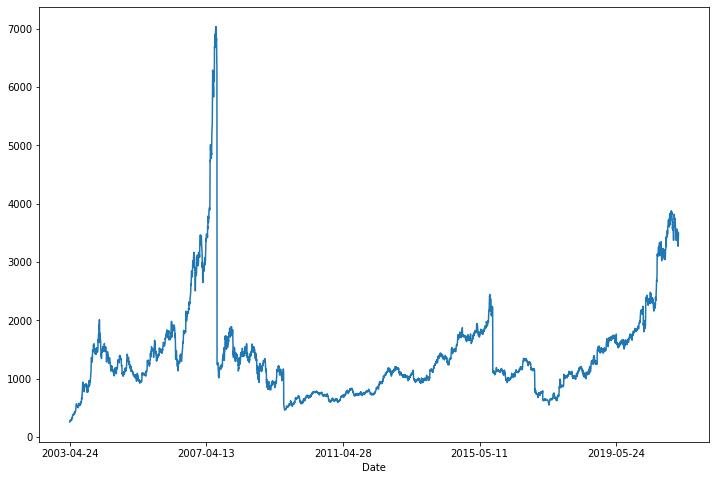

In [ ]:
ScriptWiseData[test_stock].Close.plot(figsize = (12,8))

In [ ]:
ScriptWiseData[test_stock].index.inferred_freq = 'B'

In [ ]:
xxx = ScriptWiseData[test_stock].loc[:"2005-04-25"]

In [ ]:
len(xxx)

508

In [ ]:
xxx.tail()

,Close,RSI,ATR,MACD,adx,OBV,Normalized Closing,Normalized RSI,Normalized ATR,Normalized MACD,Normalized ADX,Normalized OBV,Stock_Returns
Date,,,,,,,,,,,,,
2005-04-19,961.80,0.607406,45.4150,-14.830819,16.282105,13198371.0,369.496735,29.378198,290.423661,-156.110829,27.849634,220.242831,-1.161237
2005-04-20,958.75,0.596916,46.0525,-17.946053,16.609591,13196274.0,368.325010,28.870844,294.500400,-188.902122,28.409781,220.207838,-0.317114
2005-04-21,974.80,0.694286,46.1025,-18.901908,16.693450,13198584.0,374.490972,33.580299,294.820144,-198.963557,28.553216,220.246385,1.674055
2005-04-22,980.25,0.729711,44.2350,-19.000633,16.456665,13200624.0,376.584710,35.293686,282.877698,-200.002747,28.148209,220.280427,0.559089
2005-04-25,984.55,0.759657,44.2600,-18.518430,15.340207,13211339.0,378.236650,36.742093,283.037570,-194.927028,26.238569,220.459230,0.438664


In [ ]:
xxx.index.inferred_freq = 'B'

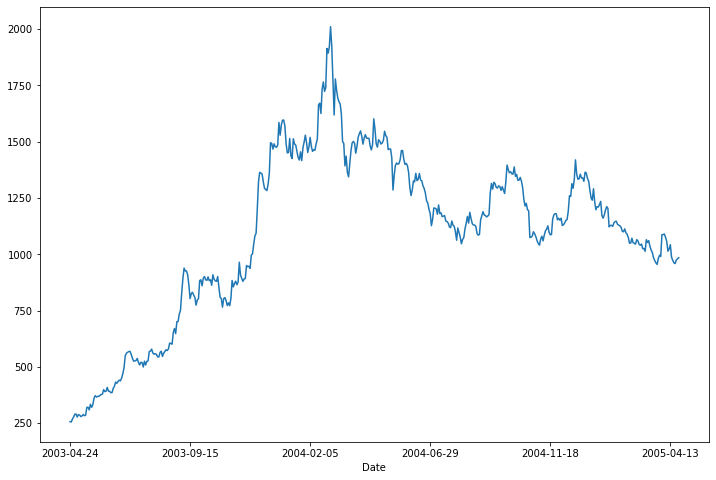

In [ ]:
xxx.Close.plot(figsize = (12,8))

In [ ]:
r = seasonal_decompose(xxx.Close, model = 'add')

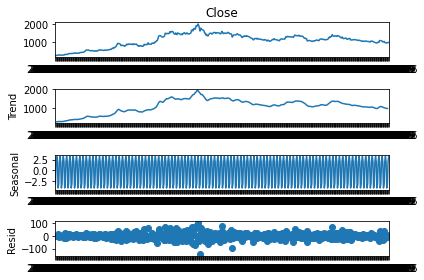

In [ ]:
r.plot();

In [ ]:
auto_arima(xxx.Close, seasonal=True, m=254,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[254] intercept   : AIC=inf, Time=879.00 sec
 ARIMA(0,1,0)(0,0,0)[254] intercept   : AIC=5084.089, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[254] intercept   : AIC=5085.846, Time=63.26 sec


# Auto Arima for SARIMAX

In [ ]:
try:
    AutoArimaResultsForSarimaxClosing = pd.read_csv('./Outputs/AutoArimaResultsForSarimaxClosing.csv')
except FileNotFoundError:
    AutoArimaResultsForSarimaxClosing = pd.DataFrame(columns=['p AR', 'd AR', 'q AR','P Seasonal', 'D Seasonal', 'Q Seasonal','M Seasonal'], index = stocks)

AutoArimaResultsForSarimaxClosing

# Tavish Code Ends -----------------------------------------

# SARIMAX MODEL

In [ ]:
def SARIMAXProcedure(stockCode):
    # decompose
    data = ScriptWiseData  [stockCode]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('b')
    data = data.fillna(method='ffill')
    decompose_result = seasonal_decompose(data['Close'], model='add')
    
    r = auto_arima(data['Close'], exogenous=data[TechnicalIndicators], maxiter=1000) #seasonality, m parameters pending
    p, d, q = r.order # define for P, D, Q, S
        
    train, test = TrainTestSplitByDateRange(data)
    
    model = SARIMAX(train['Close'], exog = train[TechnicalIndicators] ,order = (p, d, q), seasonal_order = (1,1,1,2), enforce_invertibility = False)
    results = model.fit()
    predictions = results.predict(start_date, end_date, exog=test[TechnicalIndicators]).rename('SARIMA')
    
    return decompose_result, results, predictions

In [ ]:
decompose_result, model, predictions = SARIMAXProcedure(stocks[2])

### VARMAX MODEL

In [ ]:
ScriptWiseData[stocks[0]]

In [ ]:
# Train and fit varmax model
def VARMAXProcedure(stockSymbol):
    data = ScriptWiseData[stockSymbol]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('D')
    data = data.fillna(method='ffill')
    data = data[['Close']+TechnicalIndicators]
    r = auto_arima(data['Close'], exogenous=data[TechnicalIndicators], maxiter=1000) #seasonality, m parameters pending
    p, d, q = r.order
    if(p==0 and d==0):
      p = 1
    # make data stationary based on auto arima output
    # data_transformed = DifferenceToMakeStationary(data, d)
    
    # train test split  
    train, test = TrainTestSplitByDateRange(data)
    
    # fit the model based on above parameters
    model = VARMAX(train, order=(p,q))
    results = model.fit(maxiter=1000, disp=False)
    forecasts = results.forecast(len(test))
    
    #     forecasts = InvertDifferencingForActualResults()
    return results, forecasts, test

In [ ]:
import datetime
try:
    VarmaxResults = pd.read_csv('./Outputs/VarmaxResults.csv')
except FileNotFoundError:
    VarmaxResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)
    
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
        print(datetime.datetime.now())
        if(np.isnan(VarmaxResults.loc[s, 'MAE'])):
            model, forecasts, test = VARMAXProcedure(s)
            print(f'Model Complete for {getStockNameFromStockCode(s)}')
            VarmaxResults.loc[s, ['Model']] =  model
            VarmaxResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
            VarmaxResults.loc[s, ['MAE']] =  mean_absolute_error(forecasts.Close, test.Close)
            VarmaxResults.loc[s, ['RMSE']] = mean_squared_error(forecasts.Close, test.Close, squared=False)
            VarmaxResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts.Close, test.Close)
            VarmaxResults.loc[s, ['AdjustedR2']] = r2_score(forecasts.Close, test.Close)
            VarmaxResults.loc[s, ['Noise']] = forecasts.Close.diff().abs().mean()
            VarmaxResults.to_csv('./Outputs/VarmaxResults.csv')
            print('Success')
        else:
            print('Already exists')
        print(datetime.datetime.now())
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())

## Prophet models

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_start_date = pd.to_datetime(start_date)
df_end_date = pd.to_datetime(end_date)

In [ ]:
def ProphetProcedure(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode][['Close']]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y']
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
    m = Prophet()

    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
#     test_t = test.set_index('ds')
#     future = future.set_index('ds')
#     future = test_t[].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [ ]:
def ProphetProcedureWithExogenousVariables(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode][['Close']+TechnicalIndicators]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y'] + TechnicalIndicators
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
#     return df, 1
    m = Prophet()
    for t in TechnicalIndicators:
        m.add_regressor(t)
    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
    test_t = test.set_index('ds')
    future = future.set_index('ds')
    future = test_t[TechnicalIndicators].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [ ]:
# Hyper parameter tuning
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [ ]:
try:
    ProphetSingleRegressionResults = pd.read_csv('./Outputs/ProphetSingleRegressionResults.csv')
except FileNotFoundError:
    ProphetSingleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
    

In [ ]:
# initalize result variable
for s in stocks:
    print(s)
    try:
        m, forecast, df_cv = ProphetProcedure(s)
        val_metrics = performance_metrics(df_cv)
        ProphetSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        ProphetSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['mae'][0]
        ProphetSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['mse'][0])
        t = df_cv.dropna()
        ProphetSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat)
        ProphetSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat)
        ProphetSingleRegressionResults.loc[s, ['Noise']] = t.yhat.diff().abs().mean()
        print('Success')
    except:
        print("Error Occured", sys.exc_info())
        
ProphetSingleRegressionResults.to_csv('./Outputs/ProphetSingleRegressionResults.csv')

In [ ]:
try:
    ProphetMultipleRegressionResults = pd.read_csv('./Outputs/ProphetMultipleRegressionResults.csv')
except FileNotFoundError:
    ProphetMultipleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
    

In [ ]:
# initalize result variable

for s in stocks:
    print(s)
    # try:
    m, forecast, df_cv = ProphetProcedureWithExogenousVariables(s)
    val_metrics = performance_metrics(df_cv)
    ProphetMultipleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
    ProphetMultipleRegressionResults.loc[s, ['MAE']] =  val_metrics['mae'][0]
    ProphetMultipleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['mse'][0])
    t = df_cv.dropna()
    ProphetMultipleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat)
    ProphetMultipleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat)
    ProphetMultipleRegressionResults.loc[s, ['Noise']] = t.yhat.diff().abs().mean()
    print('Success')
    # except:
    #     print("Error Occured", sys.exc_info())
        
ProphetMultipleRegressionResults.to_csv('./Outputs/ProphetMultipleRegressionResults.csv')

In [ ]:
# for plotting
df = ScriptWiseData[stocks[1]]
df.index = pd.to_datetime(df.index)
df = df.reset_index()
df.columns = ['ds', 'y'] + TechnicalIndicators

In [ ]:
results = performance_metrics(df_cv)
results.head(2)

In [ ]:
m.plot_components(forecast);

In [ ]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

df.plot(x='ds',y='y',label='Actual Price',legend=True,ax=ax) #,xlim=(df_start_date,df_end_date))

In [ ]:
plot_cross_validation_metric(df_cv, metric='rmse');

## Neural Prophet and AR-Net

In [ ]:
from neuralprophet import NeuralProphet, set_random_seed , set_log_level
set_random_seed(0)
set_log_level("ERROR")

In [ ]:
df = ScriptWiseData['BOM500180'].reset_index()
df = df[['Date', 'Close']]
df.columns = ['ds', 'y']
df.head()

### Basic Model

In [ ]:
def BuildNeuralProphetModels(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5, columnName = 'Close'):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', columnName]]
    df.columns = ['ds', 'y']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D', progress_bar = False)
    val_metrics = m.test(df_val)
    
    # make forecasts
    future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
#     future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
try:
    NPSingleRegressionResults = pd.read_csv('./Outputs/NeuralProphetSingleRegressionResults.csv')
except FileNotFoundError:
    NPSingleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)

In [ ]:
# initalize result variable
for s in stocks:
    print(s)
    try:
        m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData[s])
        NPSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        NPSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
        NPSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
        t = forecast.dropna()
        NPSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
        NPSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
        NPSingleRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()
        print('Success')
    except:
        print("Error Occured")
        
NPSingleRegressionResults.to_csv('./Outputs/NeuralProphetSingleRegressionResults.csv')

In [ ]:
NPSingleRegressionResults

#### Plot the forecast

In [ ]:
# forecasts_plot = m.plot(forecast)

In [ ]:
# fig_comp = m.plot_components(forecast);

In [ ]:
# fig_param = m.plot_parameters()

#### Validating the dataset

In [ ]:
# m = NeuralProphet()
# df_train, df_val = m.split_df(df, valid_p=0.2, freq='D')

In [ ]:
# train_metrics = m.fit(df_train, freq='D')
# val_metrics = m.test(df_val)

## Multiple regressors

In [ ]:
def BuildNeuralProphetModelsWithMultipleRegressors(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', 'Close']+TechnicalIndicators]
    df.columns = ['ds', 'y', 'A', 'B', 'C', 'D', 'E']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    # lagged regressors
    m.add_lagged_regressor(name='A')
    m.add_lagged_regressor(name='B')
    m.add_lagged_regressor(name='C')
    m.add_lagged_regressor(name='D')
    m.add_lagged_regressor(name='E')
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D',progress_bar = False)
    val_metrics = m.test(df_val)
    
    # make forecasts
    # future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
    future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
try:
    NPExogenousRegressionResults = pd.read_csv('./Outputs/NeuralProphetRegressionWithExogenousVariablesResults.csv')
except FileNotFoundError:
    NPExogenousRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)

In [ ]:
# initalize result variable
NPExogenousRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
for s in stocks:
    print(s)
    try:
        m, forecast , train_metrics, val_metrics = BuildNeuralProphetModelsWithMultipleRegressors(ScriptWiseData[s])
        NPExogenousRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        NPExogenousRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
        NPExogenousRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
        t = forecast.dropna()
        NPExogenousRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
        NPExogenousRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
        NPExogenousRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()
        print('Success')
    except:
        print("Error Occured")
        
NPExogenousRegressionResults.to_csv('./Outputs/NeuralProphetRegressionWithExogenousVariablesResults.csv')

In [ ]:
NPExogenousRegressionResults

In [ ]:
# # m = NeuralProphet()
# # metrics = m.fit(df, freq="D")
# for s in stocks:
#     print(s)
#     try:
#         m, forecast , train_metrics, val_metrics = BuildNeuralProphetModelsWithMultipleRegressors(ScriptWiseData[s])
# #         m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData[s])
#         print('Succeess')
#     except:
#         print("Error Occured")

In [ ]:
# forecasts_plot = m.plot(forecast)
# fig_comp = m.plot_components(forecast)

In [ ]:
# train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [False, False]).head(3)

In [ ]:
# train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [True, True]).head(3)

In [ ]:
# val_metrics